In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib

from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [2]:
# Create folders to store data and images
folders = ["data", "imgs"]

for folder in folders:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)

In [3]:
# Download file
url = "https://storage.googleapis.com/montco-stats/tz.csv"
orig_data_file = "./data/" + url.split("/")[-1]

if not os.path.isfile(orig_data_file):
    urllib.request.urlretrieve(url, orig_data_file)

In [4]:
df = pd.read_csv(orig_data_file)
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355710 entries, 0 to 355709
Data columns (total 8 columns):
lat          355710 non-null float64
lng          355710 non-null float64
desc         355710 non-null object
zip          310807 non-null float64
title        355710 non-null object
timeStamp    355710 non-null object
twp          355544 non-null object
e            355710 non-null int64
dtypes: float64(3), int64(1), object(4)
memory usage: 21.7+ MB


In [6]:
df.describe()

,lat,lng,zip,e
count,355710.000000,355710.000000,310807.000000,355710.0
mean,40.159250,-75.316456,19234.266374,1.0
std,0.088881,0.177358,303.015928,0.0
min,30.333596,-119.698206,7203.000000,1.0
25%,40.099908,-75.392104,19038.000000,1.0
50%,40.144526,-75.304568,19401.000000,1.0
75%,40.229008,-75.210760,19446.000000,1.0
max,41.167156,-74.280113,77316.000000,1.0


In [7]:
# Column "e" contains only 1s for all instances and is irrelevant
df.drop('e', 1, inplace=True)
# "timeStamp" will not be used in this analysis
df.drop('timeStamp', 1, inplace=True)

# Check EMS instances

In [8]:
# Select only EMS instances
df = df[df.title.str.contains('EMS')].reset_index(drop=True)
df.shape

(175245, 6)

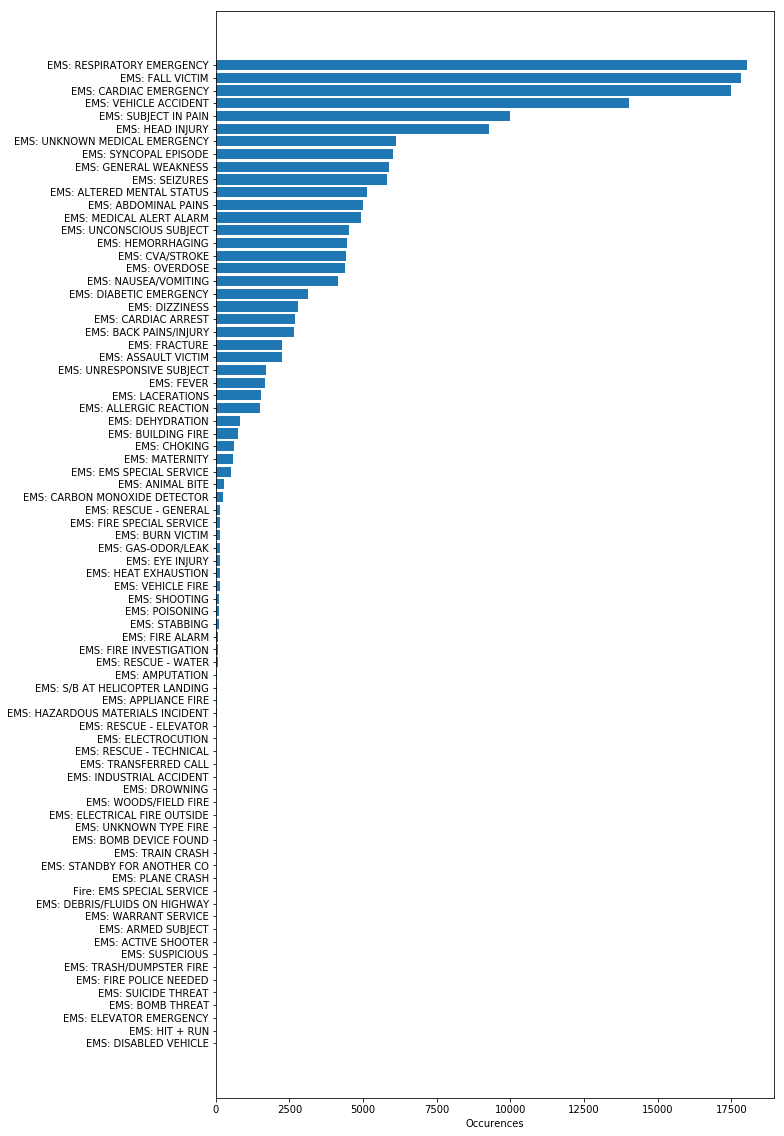

In [9]:
plt.figure(figsize=(10, 20))
title_counts = df.title.value_counts().sort_values(ascending=True)
x = range(len(title_counts))
plt.barh(x, title_counts.values)
plt.yticks(x, title_counts.index)
plt.xlabel('Occurences')
plt.show()

In [10]:
len(df[df.title.str.contains('Fire: EMS')])

5

We will keep "Fire: EMS SPECIAL SERVICE" since it indicates support to EMS events by the fire department.

# Quick integrity check

In [11]:
# Check for duplicates

print(len(df), " - Initial df length")
df = df.drop_duplicates().reset_index(drop=True)
print(len(df.drop_duplicates()), " - After removing duplicates")

175245  - Initial df length
175215  - After removing duplicates


In [12]:
# What is the structure of "desc"?

for i in range(5):
    print(df.iloc[i, :].desc)

REINDEER CT & DEAD END;  NEW HANOVER; Station 332; 2015-12-10 @ 17:10:52;
BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP; Station 345; 2015-12-10 @ 17:29:21;
AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A; 2015-12-10 @ 16:47:36;
CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; Station 329; 2015-12-10 @ 16:56:52;
CANNON AVE & W 9TH ST;  LANSDALE; Station 345; 2015-12-10 @ 15:39:04;


"desc" structure: Street & street;  township; station; date @ time.<br>
The columns "zip" and "twp" contain null values, but "desc" is complete and also contains information about location.<br>
We will use the geopy library to validate the township based on latitude and longitude values.

In [13]:
# Drop "zip"

df.drop('zip', 1, inplace=True)

# Replace "twp" (missing data) by township from "desc"

df.drop('twp', 1, inplace=True)
df['twp'] = df.desc.apply(lambda x: x.split('; ')[1])
df.twp = df.twp.str[1:]  # two spaces before township
df.twp = df.twp.str.replace(' TOWNSHIP', '')

# Plot check

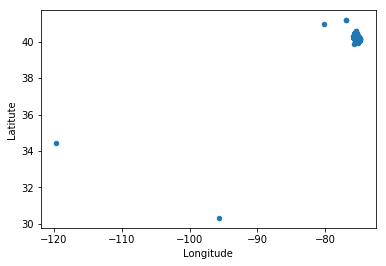

In [14]:
fig, ax = plt.subplots(1, 1)
plt.scatter(df.lng, df.lat, s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitute')
plt.show()
fig.savefig("./imgs/fig1a.png")

In [15]:
df.sort_values('lng').head(5)

,lat,lng,desc,title,twp
171820,34.420832,-119.698206,RAMP RT422 EB TO RT202 SB; CHESTER COUNTY; St...,EMS: VEHICLE ACCIDENT,CHESTER COUNTY
32898,30.333596,-95.595595,8931; MONTGOMERY; Station 311; 2016-06-02 @ 1...,EMS: CARDIAC EMERGENCY,MONTGOMERY
173909,40.969431,-80.216044,RAMP RT422 EB TO EGYPT RD; UPPER PROVIDENCE; ...,EMS: VEHICLE ACCIDENT,UPPER PROVIDENCE
4148,41.167156,-76.874030,MAIN; ; Station 308A; 2016-01-02 @ 13:01:30;,EMS: UNKNOWN MEDICAL EMERGENCY,
142462,41.167156,-76.874030,MAIN; ; Station 325; 2017-12-20 @ 21:36:45;,EMS: VEHICLE ACCIDENT,


In [16]:
df[df.lng < -75.75]

,lat,lng,desc,title,twp
4148,41.167156,-76.874030,MAIN; ; Station 308A; 2016-01-02 @ 13:01:30;,EMS: UNKNOWN MEDICAL EMERGENCY,
32898,30.333596,-95.595595,8931; MONTGOMERY; Station 311; 2016-06-02 @ 1...,EMS: CARDIAC EMERGENCY,MONTGOMERY
78113,40.198379,-75.791824,FRENCH CREEK RD & HILLSIDE LN; CHESTER COUNTY...,EMS: VEHICLE ACCIDENT,CHESTER COUNTY
124661,40.334197,-75.922495,WALNUT ST & CHERRY ST; BERKS COUNTY; Station ...,EMS: CARDIAC EMERGENCY,BERKS COUNTY
142462,41.167156,-76.874030,MAIN; ; Station 325; 2017-12-20 @ 21:36:45;,EMS: VEHICLE ACCIDENT,
159166,40.198379,-75.791824,FRENCH CREEK RD & HILLSIDE LN; CHESTER COUNTY...,EMS: UNRESPONSIVE SUBJECT,CHESTER COUNTY
171820,34.420832,-119.698206,RAMP RT422 EB TO RT202 SB; CHESTER COUNTY; St...,EMS: VEHICLE ACCIDENT,CHESTER COUNTY
173909,40.969431,-80.216044,RAMP RT422 EB TO EGYPT RD; UPPER PROVIDENCE; ...,EMS: VEHICLE ACCIDENT,UPPER PROVIDENCE


### The leftmost point is probably human error: it is situated in Texas, while the dataset should contain data from Pennsylvania.
### While the two other outliers on the upper left of the main group might be correct instances, they are too far from the others and could have a significant impact on the clustering process. We will skip the ethical discussion about their lives and just remove them from the dataset. It's a zombie apocalypse and life expectancy is dramatically reduced anyway. Stay strong, people in 41N, 77W!

In [17]:
df = df[df.lng > -76]  # Giving a death sentence to the people who live too far away.
df = df.reset_index()  # Erasing the evidences of their existence so that we don't feel any remorse. Maybe. :(

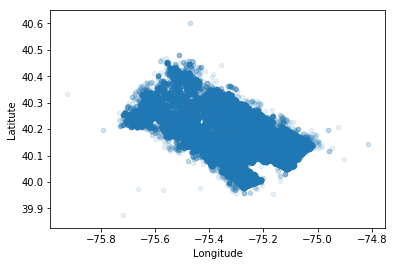

In [18]:
fig, ax = plt.subplots(1, 1)
plt.scatter(df.lng, df.lat, s=20, alpha=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitute')
plt.show()
fig.savefig("./imgs/fig1b.png")

### Although we are in a zombie crisis and might feel tempted to remove those other outliers, they are too few and relatively close to the main areas, so we'll spare these zones.

# Check if the remaining "lat" and "lng" values are correct

In [19]:
# Get township from geopy
# Only a sample of 1000 instances will be taken, due to geopy's querying limitations

llt = df[['lat', 'lng', 'twp']].sample(1000)

def get_twp(lat, lng):
    location = geolocator.reverse(str(lat) + ',' + str(lng), timeout=50)
    twp = str(location.address.split(', ')[-5])
    twp = twp.upper()
    twp = twp.replace(' TOWNSHIP', '')
    time.sleep(0.1)  # to avoid overcharging geopy
    return twp
    
llt['twp_geopy'] = llt.apply(lambda row: get_twp(row['lat'], row.lng), 1)

In [20]:
print('Matching townships [%]')
print(100.*len(llt[llt.twp == llt.twp_geopy])/len(llt))
print('Number of instances with non-matching townships')
print(len(llt[llt.twp != llt.twp_geopy]))
llt[llt.twp != llt.twp_geopy].sample(10)

Matching townships [%]
88.2
Number of instances with non-matching townships
118


,lat,lng,twp,twp_geopy
150687,40.074108,-75.158311,CHELTENHAM,PHILADELPHIA
16056,40.072731,-75.155969,CHELTENHAM,PHILADELPHIA
112144,40.228449,-75.662465,CHESTER COUNTY,NORTH COVENTRY
116189,40.170009,-75.222714,LOWER GWYNEDD,AMBLER
68432,40.214001,-75.670682,CHESTER COUNTY,NORTH COVENTRY
104289,40.099020,-75.349908,UPPER MERION,BRIDGEPORT
36963,40.136020,-75.354606,WEST NORRITON,NORRISTOWN
100155,40.109093,-75.272645,PLYMOUTH,WHITEMARSH
115912,40.182951,-75.116078,HORSHAM,WARMINSTER
159719,40.187314,-75.184610,HORSHAM,AMBLER


88.2% of instances are correct. A manual verification of a sample of non-matching instances indicates that the townships identified by geopy are adjacent to those from the original dataset.

# Clustering

In [19]:
X = df[['lng', 'lat']].values  # Data for the clustering algorithm

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### We will check if 5 is the best number of emergency stations or if we could reallocate the funding to another area / request more stations, if possible

In [21]:
wss = []  # within-cluster sum of squares
ns = range(2, 11)
for i in ns:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=20, random_state=0)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

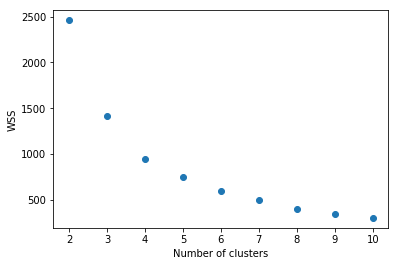

In [22]:
plt.scatter(ns, wss)
plt.xticks(ns)
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()

### 5 emergency stations is indeed around the zone of best return on investment, according to the elbow analysis.

In [23]:
# Applying k-means for 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=20, random_state=0)
y = kmeans.fit_predict(X)

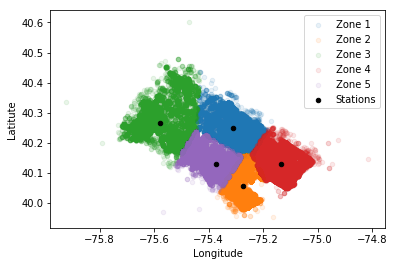

In [26]:
fig, ax = plt.subplots(1, 1)

for _y in np.unique(y):
    plt.scatter(X[y == _y, 0], X[y == _y, 1], label='Zone ' + str(_y+1), s=20, alpha=0.1)

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Stations', c='black', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitute')
plt.legend()
plt.show()
fig.savefig("./imgs/fig2.png")

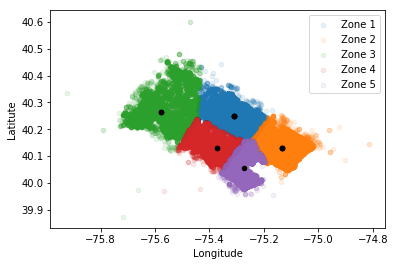

In [25]:
fig, ax = plt.subplots(1, 1)

for _y in np.unique(y):
    plt.scatter(X[y == _y, 0], X[y == _y, 1], label='Zone ' + str(_y+1), s=20, alpha=0.1)

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitute')
plt.legend()
plt.show()
fig.savefig("./imgs/fig2.png")

In [29]:
# Get the coordinates of each station

kmeans.cluster_centers_

array([[-75.31006624,  40.2494597 ],
       [-75.13525705,  40.12902289],
       [-75.57755735,  40.26548539],
       [-75.37227279,  40.12866376],
       [-75.27209891,  40.05503133]])